<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/11-gans/MLDM_2021_seminar11_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement a GAN with convolutional architecture (2 points)

Build your own CNN architecture to improve the quality of generated images for the same dataset we used during the practical session.

You may reuse the code given below, or you may change/improve it as well.

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output

2.7.0


In [27]:
from IPython.display import clear_output
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteV0QDFJ/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:14<00:00, 924.14it/s]


In [4]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [51]:
ll = tf.keras.layers 

LATENT_DIM = 96

generator = tf.keras.Sequential([
  ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  ll.Dense(64, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  ll.Dense(64, activation='selu'),
  ll.Dropout(0.1),
  ll.Dense(32, activation='selu'),
  ll.Dropout(0.1),
  ll.Dense(1),
])

generator.summary()
discriminator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 32)                3104      
                                                                 
 dense_75 (Dense)            (None, 64)                2112      
                                                                 
 dense_76 (Dense)            (None, 3888)              252720    
                                                                 
 reshape_24 (Reshape)        (None, 36, 36, 3)         0         
                                                                 
Total params: 257,936
Trainable params: 257,936
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_25 (Reshape)   

In [52]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))


@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  shape = (len(batch), 1)
  labels_real = tf.ones (shape=shape)
  labels_fake = tf.zeros(shape=shape)

  X = tf.concat([real, fake], axis=0)
  y = tf.concat([labels_real, labels_fake], axis=0)

  loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(y, discriminator(X, training=True))
  )
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss


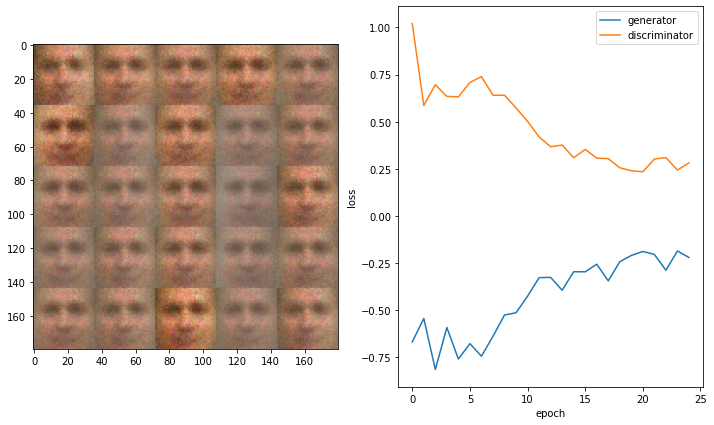

Done with epoch # 24


In [53]:
BATCH_SIZE = 256

N_EPOCHS = 25

NUM_DISC_STEPS = 8

i_disc_step = 0
losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss_gen = []
  epoch_loss_disc = []
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss_disc.append(disc_step(batch).numpy())
    else:
      # generator update
      i_disc_step = 0
      epoch_loss_gen.append(gen_step(batch).numpy())

  losses_gen.append(np.mean(epoch_loss_gen))
  losses_disc.append(np.mean(epoch_loss_disc))

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep)

# Implement a [Wasserstein GAN](https://arxiv.org/abs/1704.00028) with gradient penalty term (4 points)

Replace previously build model with WGAN, you may reuse the code above. The dataset is the same, but you may use MNIST in case you want to perform a conditional generation.

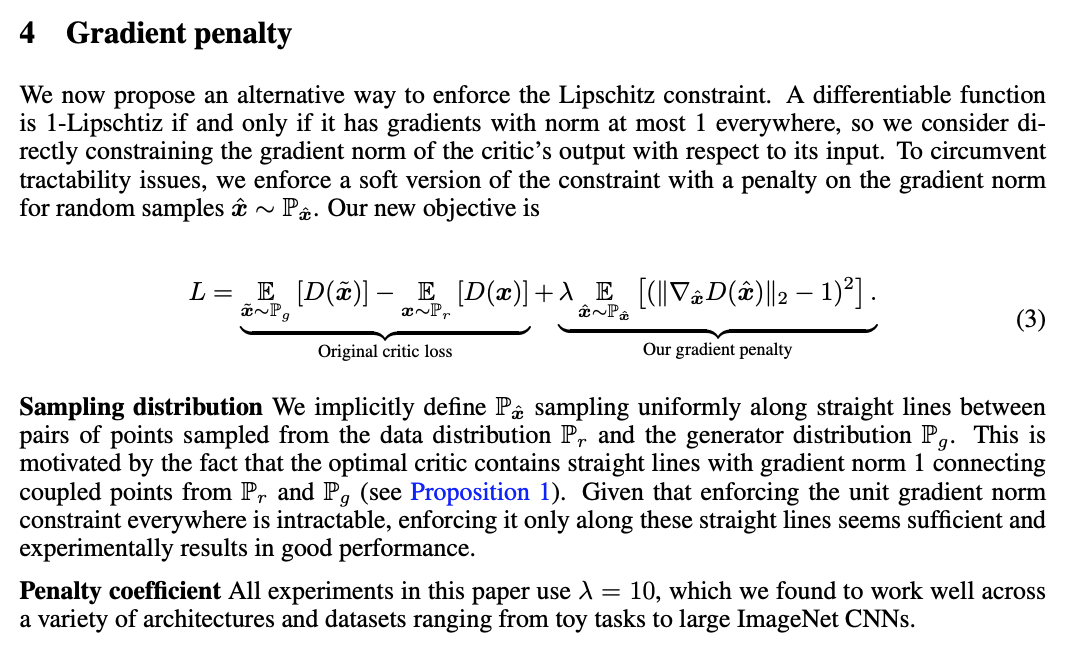

In [ ]:
<YOUR SOLUTION>